<a href="https://colab.research.google.com/github/yerzhanimanmalik/skoltech-courses/blob/master/MRI_3DUnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/drive/1DedzlRT-yCVz4cyZmy05TblRspbiVIBU" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **MRI segmentation with 3D U-net**

#### 1. Introduction

In this section we will segment gray matter and subcortical nuclei from preprocessed MRI image.

*Proceeding with this Notebook you confirm your personal acess [to the data](https://www.humanconnectome.org/study/hcp-young-adult/document/1200-subjects-data-release). 
 And your agreement on data [terms and conditions](https://www.humanconnectome.org/study/hcp-young-adult/data-use-terms).*


In [1]:
import scipy as sp
import scipy.misc
import matplotlib.pyplot as plt
import numpy as np
import os
%matplotlib inline

In [2]:
!pip install --quiet --upgrade comet_ml
from comet_ml import Experiment
    
# Add the following code anywhere in your machine learning file
experiment = Experiment(api_key="kYVqzmHEUN7WQLo86k2bZs1Z7",
                        project_name="mri-segmentation", workspace="kondratevakate")

     |████████████████████████████████| 225kB 4.9MB/s 
     |████████████████████████████████| 501kB 14.6MB/s 
     |████████████████████████████████| 204kB 20.1MB/s 


COMET INFO: Experiment is live on comet.ml https://www.comet.ml/kondratevakate/mri-segmentation/ce8f9caff9c7495e9fe9ec65bd37b11a



The code is adopted from `Torchio` library tutorials, and used in MRI epilepsy detection experiment. See https://github.com/kondratevakate/mri-epilepsy-segmentation

!! And tutorial: https://colab.research.google.com/drive/112NTL8uJXzcMw4PQbUvMQN-WHlVwQS3i

#### 2. Mounting Google drive

Mounting Google Drive to Collab Notebook. You should go with the link and enter your personal authorization code:

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
data_dir = '/content/drive/My Drive/data/seminars/anat/fs_segmentation'

In [ ]:
len(os.listdir(data_dir))

In [9]:
os.listdir(data_dir)[-30:-20]

['HCP_T1_fs6_122317_aparc+aseg.nii.gz',
 'HCP_T1_fs6_123420_aparc+aseg.nii.gz',
 'HCP_T1_fs6_122620_aparc+aseg.nii.gz',
 'HCP_T1_fs6_122418_aparc+aseg.nii.gz',
 'HCP_T1_fs6_122822_aparc+aseg.nii.gz',
 'HCP_T1_fs6_123521_aparc+aseg.nii.gz',
 'HCP_T1_fs6_123117_aparc+aseg.nii.gz',
 'HCP_T1_fs6_123723_aparc+aseg.nii.gz',
 'HCP_T1_fs6_123824_aparc+aseg.nii.gz',
 'HCP_T1_fs6_123925_aparc+aseg.nii.gz']

#### 3. Defining the dataset

Defining the working dataset, there:

 1. `norm` - normalised `T1` image processed with Freesurfer 6.0,

 2. `aparc+aseg` segmentation mask for gray matter and subcortical nuclei from Freesufer 6.0 `recon all` pipeline.

 And U-net model will treat `norm` image as input and `aparc+aseg` as target model.

In [11]:
import pandas as pd
labels_dir  = '/content/drive/My Drive/data/seminars/anat/'
labels = pd.read_csv(labels_dir + 'unrestricted_hcp_freesurfer.csv')

Defining new `pd.Dataframe()` with `Subject`, `norm` and `target` files:

In [12]:
data_list = pd.DataFrame(columns = ['Subject','norm','aseg'])

In [13]:
data_list['Subject'] = labels['Subject']

Iterating through files and `Subjects` in ID list:

In [14]:
from tqdm import tqdm

for i in tqdm(os.listdir(data_dir)):
  for j in range(0, len(data_list['Subject'])):

    if str(data_list['Subject'].iloc[j]) in i:
      if 'norm' in i: # copying path to the column norm
        data_list['norm'].iloc[j] = data_dir +'/'+ i
      elif 'aseg' in i: # copying path to second column
        data_list['aseg'].iloc[j] = data_dir +'/'+ i
      
data_list.dropna(inplace= True)

  0%|          | 0/854 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
100%|██████████| 854/854 [00:10<00:00, 79.05it/s]


In [ ]:
data_list.head()

,Subject,norm,aseg
4,101006,/content/drive/My Drive/Skoltech Neuroimaging/...,/content/drive/My Drive/Skoltech Neuroimaging/...
5,101107,/content/drive/My Drive/Skoltech Neuroimaging/...,/content/drive/My Drive/Skoltech Neuroimaging/...
6,101309,/content/drive/My Drive/Skoltech Neuroimaging/...,/content/drive/My Drive/Skoltech Neuroimaging/...
7,101410,/content/drive/My Drive/Skoltech Neuroimaging/...,/content/drive/My Drive/Skoltech Neuroimaging/...
8,101915,/content/drive/My Drive/Skoltech Neuroimaging/...,/content/drive/My Drive/Skoltech Neuroimaging/...


Let's have a closer look on the data:

In [ ]:
data_list['norm'].iloc[0]

'/content/drive/My Drive/Skoltech Neuroimaging/NeuroML2020/data/seminars/anat/fs_segmentation/HCP_T1_fs6_101006_norm.nii.gz'

     |████████████████████████████████| 2.5MB 4.8MB/s 


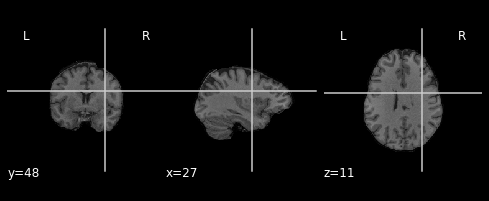

In [ ]:
!pip install --quiet --upgrade nilearn
import nilearn
from nilearn import plotting

# visualising normalised image
img = nilearn.image.load_img(data_list['norm'].iloc[0])
plotting.plot_anat(img)

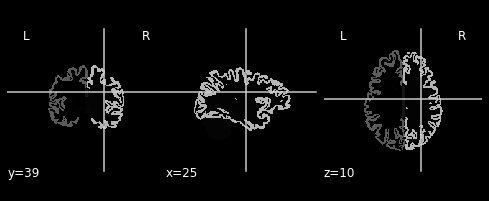

In [ ]:
# visualising segmentation
img = nilearn.image.load_img(data_list['aseg'].iloc[0])
plotting.plot_anat(img)

In [ ]:
np.unique(img.get_data())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  """Entry point for launching an IPython kernel.


array([   0,    2,    3,    4,    5,    7,    8,   10,   11,   12,   13,
         14,   15,   16,   17,   18,   24,   26,   28,   30,   31,   41,
         42,   43,   44,   46,   47,   49,   50,   51,   52,   53,   54,
         58,   60,   62,   63,   77,   85,  251,  252,  253,  254,  255,
       1000, 1001, 1002, 1003, 1005, 1006, 1007, 1008, 1009, 1010, 1011,
       1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022,
       1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033,
       1034, 1035, 2000, 2001, 2002, 2003, 2005, 2006, 2007, 2008, 2009,
       2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020,
       2021, 2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030, 2031,
       2032, 2033, 2034, 2035], dtype=int32)

Any suggestions on these numbers?

#### 4. Writing dataloader

We will use `TorchIO` library: https://torchio.readthedocs.io/

In [ ]:
!pip install --quiet --upgrade torchio

     |████████████████████████████████| 112kB 4.5MB/s 
     |████████████████████████████████| 42.5MB 72kB/s 


In [ ]:
import torchio 
import enum
"""
    Code adapted from: https://github.com/fepegar/torchio#credits

        Credit: Pérez-García et al., 2020, TorchIO: 
        a Python library for efficient loading, preprocessing, 
        augmentation and patch-based sampling of medical images in deep learning.

"""

CHANNELS_DIMENSION = 1
SPATIAL_DIMENSIONS = 2, 3, 4

MRI = 'MRI'
LABEL = 'LABEL'

LIST_ASEG =  [ 8,   10,   11,   12,   13,    16,   17,   18,  26,  47, 49,   50, 
  51,   52,   53,   54,   58,  85,  251,  252,  253,  254,  255] # gray matter segmentation labels

class Action(enum.Enum):
    TRAIN = 'Training'
    VALIDATE = 'Validation'

def get_torchio_dataset(inputs, targets, transform):
    """
    The function creates dataset from the list of files from cunstumised dataloader.
    """
    subjects = []
    for (image_path, label_path) in zip(inputs, targets):
        subject_dict = {
            MRI : torchio.Image(image_path, torchio.INTENSITY),
            LABEL: torchio.Image(label_path, torchio.LABEL),
        }
        subject = torchio.Subject(subject_dict)
        subjects.append(subject)
    
    if transform:
        dataset = torchio.SubjectsDataset(subjects, transform = transform)
    elif not transform:
        dataset = torchio.SubjectsDataset(subjects)
    
    return  dataset , subjects

In [ ]:
data, subjects = get_torchio_dataset(data_list['norm'], data_list['aseg'], False)

In [ ]:
data[0]['MRI']

Image(shape: (1, 256, 256, 256); spacing: (1.00, 1.00, 1.00); orientation: LIA+; memory: 64.0 MiB; type: intensity)

#### 3. Writing visualization tools for torch tensors


In [ ]:
import matplotlib.pyplot as plt
import torch
import numpy as np
import nibabel

def plot_central_cuts(img, title=""):
    """
    param image: tensor or np array of shape (CxDxHxW) if t is None
    """
    if isinstance(img, torch.Tensor):
        img = img.numpy()
        if (len(img.shape) > 3):
            img = img[0,:,:,:]
                
    elif isinstance(img, nibabel.nifti1.Nifti1Image):    
        img = img.get_fdata()
   
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(3 * 4, 4))
    axes[0].imshow(img[ img.shape[0] // 2, :, :])
    axes[1].imshow(img[ :, img.shape[1] // 2, :])
    axes[2].imshow(img[ :, :, img.shape[2] // 2])
    
    plt.show()
    
def plot_predicted(img, seg, delta = 0, title=""):
    """
    param image: tensor or np array of shape (CxDxHxW) if t is None
    """
    if isinstance(img, torch.Tensor):
        img = img.cpu().numpy()
        if (len(img.shape) == 5):
            img = img[0,0,:,:,:]
        elif (len(img.shape) == 4):
            img = img[0,:,:,:]
                
    elif isinstance(img, nibabel.nifti1.Nifti1Image):    
        img = img.get_fdata()
        
    if isinstance(seg, torch.Tensor):
        seg= seg[0].cpu().numpy().astype(np.uint8)
   
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(3 * 4, 4))
    axes[0].imshow(img[ img.shape[0] // 2 + delta, :, :])
    axes[1].imshow(seg[ seg.shape[0] // 2 + delta, :, :])
    intersect = img[ img.shape[0] // 2 + delta, :, :] + seg[ seg.shape[0] // 2 + delta, :, :]*100
    axes[2].imshow(intersect, cmap='gray')
    
    plt.show()

The class `dataset` inherits from `torch.utils.data.Dataset.` It receives as input a list of torchio.Subject instances and an optional `torchio.transforms.Transform.`

The inputs to the subject class are instances of torchio.Image, such as torchio.ScalarImage or torchio.LabelMap. The image class will be used by the transforms to decide whether or not to perform the operation. For example, spatial transforms must apply to both, but intensity transforms must apply to scalar images only.

https://torchio.readthedocs.io/data/dataset.html

In [ ]:
from torch.utils.data import DataLoader, Subset
from torchio import AFFINE, DATA, PATH, TYPE, STEM

Dataset size: 427
Image shape: (1, 256, 256, 256)
Segmentation shape: (1, 256, 256, 256)


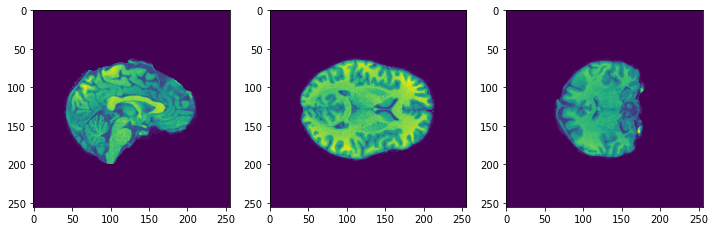

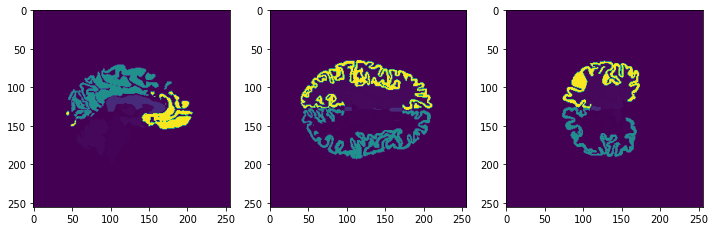

In [ ]:
print("Dataset size: {}".format(len(data)))
img = data[0][MRI]
seg = data[0][LABEL]
print("Image shape: {}".format(img.shape))
print("Segmentation shape: {}".format(seg.shape))
plot_central_cuts(img[DATA])
plot_central_cuts(seg[DATA])

## 2. Whole brain segmentation

Let's define the experiment for whole brain segmentation:

In [ ]:
experiment.set_name("Whole image based, 1 subject in batch")

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.models.vgg import vgg11_bn
from torch.autograd import Function, Variable
import random
import numpy as np

import sys
import os
from optparse import OptionParser

import torch.backends.cudnn as cudnn
from torch import optim
import time

import pandas as pd

In [ ]:
!pip install --quiet --upgrade unet 
from IPython.display import clear_output
import matplotlib.pyplot as plt
from unet import UNet

from sklearn.model_selection import StratifiedKFold, ShuffleSplit
from torch.utils.data import DataLoader, Subset
import warnings
import multiprocessing

In [ ]:
num_subjects = len(data)
training_split_ratio = 1/2
num_training_subjects = int(training_split_ratio * num_subjects)

# training_subjects = subjects[:num_training_subjects]
# validation_subjects = subjects[num_training_subjects:]

training_subjects = subjects[:20]
validation_subjects = subjects[20:40] # experimenting just on 20 first subjects

training_set = torchio.SubjectsDataset(
    training_subjects, transform=None)

validation_set = torchio.SubjectsDataset(
    validation_subjects, transform=None)

print('Training set:', len(training_set), 'subjects')
print('Validation set:', len(validation_set), 'subjects')

Training set: 20 subjects
Validation set: 20 subjects


The data is really heavy, so lets try to start with 1 subject/ batch:

In [ ]:
training_batch_size = 1
validation_batch_size = 1

training_loader = torch.utils.data.DataLoader(
    training_set,
    batch_size=training_batch_size,
    shuffle=True,
    num_workers=multiprocessing.cpu_count(),
)

validation_loader = torch.utils.data.DataLoader(
    validation_set,
    batch_size=validation_batch_size,
    num_workers=multiprocessing.cpu_count(),
)

#### Defining the model and optimizer for training

At first check if we have GPU onborad:

In [ ]:
 torch.cuda.is_available()

True

In [ ]:
if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

In [ ]:
def get_iou_score(prediction, ground_truth):
    intersection, union = 0, 0
    intersection += np.logical_and(prediction > 0, ground_truth > 0).astype(np.float32).sum() 
    union += np.logical_or(prediction > 0, ground_truth > 0).astype(np.float32).sum()
    iou_score = float(intersection) / union
    return iou_score

def calculate_metrics(surface, prediction):
    dsc = compute_dice_coefficient(surface, prediction)
    asd_mean, asd_std = compute_average_surface_distance(
        compute_surface_distances(
            surface, prediction, spacing_mm=(1,1,1))
    )
    
    iou = get_iou_score(prediction, surface)
    
    return dsc, asd_mean, asd_std, iou        
        
## see more in https://github.com/deepmind/surface-distance
def validate_dsc_asd(model, loader):
    
    dsc, asd_mean, asd_std, iou = [], [], [], []
    model.eval()

    for batch_idx, batch in enumerate(tqdm(loader)):
            inputs, targets = prepare_batch(batch, device)
            with torch.no_grad():
                logits = forward(model, inputs)
            labels = logits.argmax(dim=CHANNELS_DIMENSION)
            prediction = labels[0].cpu().numpy().astype(np.uint8)
            dsc_temp, asd_mean_temp, asd_std_temp, iou_temp = calculate_metrics(
                targets.cpu().numpy().astype(np.uint8)[0][0], 
                prediction
            )
            dsc.append(dsc_temp)
            asd_mean.append(asd_mean_temp)
            asd_std.append(asd_std_temp)
            iou.append(iou_temp)
    
    return dsc, asd_mean, asd_std, iou

def prepare_batch(batch, device):
    """
    The function loaging *nii.gz files, sending to the devise.
    For the LABEL in binarises the data.
    """
    inputs = batch[MRI][DATA].to(device)
    targets = batch[LABEL][DATA]
    targets[0][0][(np.isin(targets[0][0], LIST_ASEG))] = 1
    targets[targets >= 1000] = 1
    targets[targets != 1] = 0
    targets = targets.to(device)    
    return inputs, targets

def get_dice_score(output, target, SPATIAL_DIMENSIONS = (2, 3, 4), epsilon=1e-9):
    p0 = output
    g0 = target
    p1 = 1 - p0
    g1 = 1 - g0
    tp = (p0 * g0).sum(dim=SPATIAL_DIMENSIONS)
    fp = (p0 * g1).sum(dim=SPATIAL_DIMENSIONS)
    fn = (p1 * g0).sum(dim=SPATIAL_DIMENSIONS)
    num = 2 * tp
    denom = 2 * tp + fp + fn + epsilon
    dice_score = num / denom
    return dice_score

def get_dice_loss(output, target):
    return 1 - get_dice_score(output, target)

def forward(model, inputs):
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=UserWarning)
        logits = model(inputs)
    return logits

def run_epoch(epoch_idx, action, loader, model, optimizer, scheduler=False, experiment= False):
    is_training = action == Action.TRAIN
    epoch_losses = []
    model.train(is_training)
    
    for batch_idx, batch in enumerate(tqdm(loader)):
        inputs, targets = prepare_batch(batch, device)
        optimizer.zero_grad()
        
        with torch.set_grad_enabled(is_training):
            logits = forward(model, inputs)
            probabilities = F.softmax(logits, dim=CHANNELS_DIMENSION)
            batch_losses = get_dice_loss(probabilities, targets)
            batch_loss = batch_losses.mean()
            
            if is_training:
                batch_loss.backward()
                optimizer.step()
                
            # appending the loss
            epoch_losses.append(batch_loss.item())
           
            if experiment:
                if action == Action.TRAIN:
                    experiment.log_metric("train_dice_loss", batch_loss.item())
                elif action == Action.VALIDATE:
                    experiment.log_metric("validate_dice_loss", batch_loss.item())
                    
            del inputs, targets, logits, probabilities, batch_losses
    
    epoch_losses = np.array(epoch_losses)
#     print(f'{action.value} mean loss: {epoch_losses.mean():0.3f}')
    
    return epoch_losses 

def train(num_epochs, training_loader, validation_loader, model, optimizer, scheduler,
          weights_stem, save_epoch= 1, experiment= False, verbose = True):
    
    start_time = time.time()
    epoch_train_loss, epoch_val_loss = [], []
    
    run_epoch(0, Action.VALIDATE, validation_loader, model, optimizer, scheduler, experiment)
    
    for epoch_idx in range(1, num_epochs + 1):
        
        epoch_train_losses = run_epoch(epoch_idx, Action.TRAIN, training_loader, 
                                       model, optimizer, scheduler, experiment)
        epoch_val_losses = run_epoch(epoch_idx, Action.VALIDATE, validation_loader, 
                                     model, optimizer, scheduler, experiment)
        
        # 4. Print metrics
        if verbose:
            clear_output(True)
            print("Epoch {} of {} took {:.3f}s".format(epoch_idx, num_epochs, time.time() - start_time))
            print("  training loss (in-iteration): \t{:.6f}".format(epoch_train_losses[-1]))
            print("  validation loss: \t\t\t{:.6f}".format(epoch_val_losses[-1]))    
        
        epoch_train_loss.append(np.mean(epoch_train_losses))
        epoch_val_loss.append(np.mean(epoch_val_losses))
        
        # 5. Plot metrics
        if verbose:
            plt.figure(figsize=(10, 5))
            plt.plot(epoch_train_loss, label='train')
            plt.plot(epoch_val_loss, label='val')
            plt.xlabel('epoch')
            plt.ylabel('loss')
            plt.legend()
            plt.show()
        
        if scheduler:     
            scheduler.step(np.mean(epoch_val_losses))
        # comet ml
        if experiment:
            experiment.log_epoch_end(epoch_idx)
        #saving the model
        # if (epoch_idx% save_epoch == 0):
        #     torch.save(model.state_dict(), f'weights/{weights_stem}_epoch_{epoch_idx}.pth')

In [ ]:
def get_model_and_optimizer(device, num_encoding_blocks=3, out_channels_first_layer=4, patience=3):
  #Better to train with num_encoding_blocks=3, out_channels_first_layer=16 '''
  #repoducibility
  torch.manual_seed(0)
  np.random.seed(0)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False
    
  model = UNet(
        in_channels=1,
        out_classes=2,
        dimensions=3,
        num_encoding_blocks=num_encoding_blocks,
        out_channels_first_layer=out_channels_first_layer,
        normalization='batch',
        upsampling_type='linear',
        padding=True,
        activation='PReLU',
    ).to(device)
    
  optimizer = torch.optim.AdamW(model.parameters())
#     scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.7)
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=patience, threshold=0.01)
    
  return model, optimizer, scheduler

model, optimizer, scheduler = get_model_and_optimizer(device)

Epoch 5 of 5 took 820.510s
  training loss (in-iteration): 	0.844099
  validation loss: 			0.871322


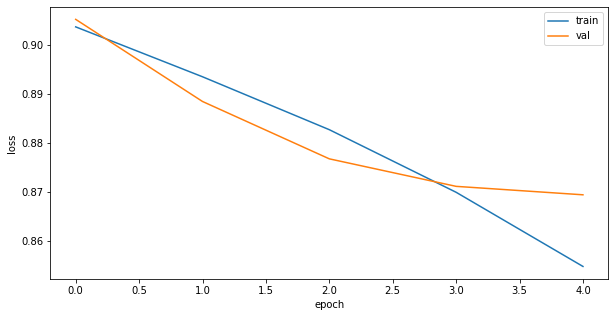

In [ ]:
torch.cuda.empty_cache()

num_epochs = 5
weights_stem = 'whole_images'
train(num_epochs, training_loader, validation_loader, model, optimizer, scheduler = False,  weights_stem = weights_stem )

We expect to get `DICE > 0.9` on validation after 40 epochs on the whole sample.

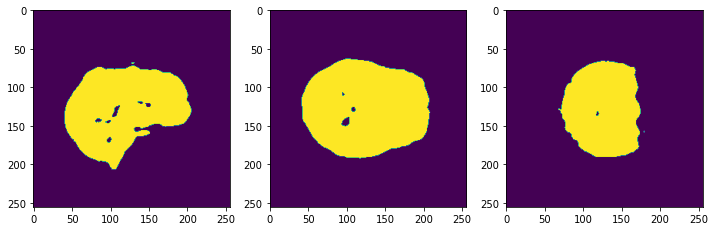

In [ ]:
batch = next(iter(validation_loader))
model.eval()
inputs, targets = prepare_batch(batch, device)
with torch.no_grad():
    logits = forward(model, inputs)
labels = logits.argmax(dim=CHANNELS_DIMENSION)
foreground = labels[0].cpu().numpy().astype(np.uint8)
plot_central_cuts(foreground)

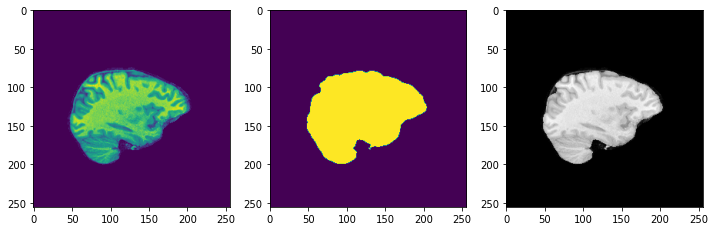

In [ ]:
plot_predicted(inputs, foreground, 30, title="")

## 3. Patch-based segmentation

Let's fedine another experiment within the same workspace in `COMET ML`:

In [ ]:
experiment.set_name("Patch based, 64 batch")

In [ ]:
patch_size = 64
samples_per_volume = 8
max_queue_length = 240
training_batch_size = 16
validation_batch_size = 16

patches_training_set = torchio.Queue(
    subjects_dataset=training_set,
    max_length=max_queue_length,
    samples_per_volume=samples_per_volume,
    sampler=torchio.sampler.UniformSampler(patch_size),
    num_workers=multiprocessing.cpu_count(),
    shuffle_subjects=True,
    shuffle_patches=True,
)

patches_validation_set = torchio.Queue(
    subjects_dataset=validation_set,
    max_length=max_queue_length,
    samples_per_volume=samples_per_volume,
    sampler=torchio.sampler.UniformSampler(patch_size),
    num_workers=multiprocessing.cpu_count(),
    shuffle_subjects=False,
    shuffle_patches=False,
)

training_loader = torch.utils.data.DataLoader(
    patches_training_set, batch_size=training_batch_size)

validation_loader = torch.utils.data.DataLoader(
    patches_validation_set, batch_size=validation_batch_size)

In [ ]:
import SimpleITK as sitk

def train(num_epochs, training_loader, validation_loader, model, optimizer, weights_stem):
    run_epoch(0, Action.VALIDATE, validation_loader, model, optimizer)
    for epoch_idx in range(1, num_epochs + 1):
        print('Starting epoch', epoch_idx)
        run_epoch(epoch_idx, Action.TRAIN, training_loader, model, optimizer)
        run_epoch(epoch_idx, Action.VALIDATE, validation_loader, model, optimizer)
        experiment.log_epoch_end(epoch_idx)
        
        
def run_epoch(epoch_idx, action, loader, model, optimizer):
    is_training = action == Action.TRAIN
    epoch_losses = []
    model.train(is_training)
    for batch_idx, batch in enumerate(tqdm(loader)):
        inputs, targets = prepare_batch(batch, device)
        optimizer.zero_grad()
        with torch.set_grad_enabled(is_training):
            logits = forward(model, inputs)
            probabilities = F.softmax(logits, dim=CHANNELS_DIMENSION)
            batch_losses = get_dice_loss(probabilities, targets)
            batch_loss = batch_losses.mean()
            if is_training:
                batch_loss.backward()
                optimizer.step()
            epoch_losses.append(batch_loss.item())
            if action == Action.TRAIN:
                experiment.log_metric("train_dice_loss", batch_loss.item())
            elif action == Action.VALIDATE:
                experiment.log_metric("validate_dice_loss", batch_loss.item())
    epoch_losses = np.array(epoch_losses)
    
    print(f'{action.value} mean loss: {epoch_losses.mean():0.3f}')

In [ ]:
model, optimizer, scheduler = get_model_and_optimizer(device)

num_epochs = 5

weights_stem = 'patches'
train(num_epochs, training_loader, validation_loader, model, optimizer, weights_stem)

  0%|          | 0/20 [00:00<?, ?it/s]

Validation mean loss: 0.920
Starting epoch 1


  0%|          | 0/20 [00:00<?, ?it/s]

Training mean loss: 0.904


  0%|          | 0/20 [00:00<?, ?it/s]

Validation mean loss: 0.910
Starting epoch 2


  0%|          | 0/20 [00:00<?, ?it/s]

Training mean loss: 0.894


  0%|          | 0/20 [00:00<?, ?it/s]

Validation mean loss: 0.910
Starting epoch 3


  0%|          | 0/20 [00:00<?, ?it/s]

Training mean loss: 0.883


  0%|          | 0/20 [00:00<?, ?it/s]

Validation mean loss: 0.890
Starting epoch 4


  0%|          | 0/20 [00:00<?, ?it/s]

Training mean loss: 0.871


  0%|          | 0/20 [00:00<?, ?it/s]

Validation mean loss: 0.868
Starting epoch 5


  0%|          | 0/20 [00:00<?, ?it/s]

Training mean loss: 0.855


100%|██████████| 20/20 [00:41<00:00,  2.09s/it]

Validation mean loss: 0.860


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/usr/local/lib/python3.6/dist-packages/torchio/data/inference/aggregator.py:116: UserWarning: Medical image frameworks such as ITK do not support int64. Casting to int32...
  warnings.warn(message)


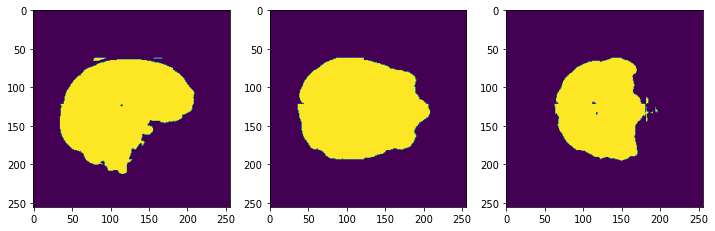

In [ ]:
import nibabel as nib
sample = random.choice(validation_set)
input_tensor = sample[MRI][DATA][0]
patch_size = 64, 64, 64  # we can user larger or smaller patches for inference
patch_overlap = 4, 4, 4
grid_sampler = torchio.inference.GridSampler(
    sample,
    patch_size,
    patch_overlap,
)
patch_loader = torch.utils.data.DataLoader(
    grid_sampler, batch_size=validation_batch_size)
aggregator = torchio.inference.GridAggregator(grid_sampler)

model.eval()
with torch.no_grad():
    for patches_batch in patch_loader:
        inputs = patches_batch[MRI][DATA].to(device)
        locations = patches_batch['location']
        logits = model(inputs)
        labels = logits.argmax(dim=CHANNELS_DIMENSION, keepdim=True)
        aggregator.add_batch(labels, locations)
plot_central_cuts(aggregator.get_output_tensor())

Again we expect to see DICE > 0.85 after 40 epochs.

## 4. What else?
1. Transforms (histogtam standartization)
2. Augmentations for patch based segmentation
3. Autoencoding architectures